In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import palettable
import squarify

import connectheroku as cheroku # connect database function
import warnings; warnings.filterwarnings(action='once')

In [2]:
large = 22; med = 16; small = 12
params = {'axes.titlesize' : large,
          'legend.fontsize' : med,
          'figure.figsize' : (16, 10),
          'axes.labelsize' : med,
          'xtick.labelsize' : med,
          'ytick.labelsize' : med,
          'figure.titlesize' : large
}
plt.rcParams.update(params)
sns.set_style('whitegrid')
all_shapes = list(mpl.markers.MarkerStyle.markers.keys())
blue, orange = sns.color_palette()[:2]

In [3]:
credential_file = '/Users/aliglara/Documents/MyGit/apis/credential_keys.json'

# Introduction 
## Scope

The goal of this project was to create a data-driven tool to visualize whether there is a link between rising rent cost and homelessness among people who possesses a bachelor's degree or above in the United States.

## Dataset

The data used in this project was obtained from two US-official sources between 2015 to 2020.

First, the estimated US population will be grabbed from the US Census website, filtered by the following topics:

1. Geography > Nation > United States
2. Population and People > Population and People

Besides the broad information that can be obtained, this project was focused on the following features:

- Name of the state
- Year
- Total population
- Population in households
- Educational attainment
- Employment status
- Income
- Housing tenure
- Gross rent cost

Second, The estimate of homelessness population by state was pulled out from the HUD Exchange website

**The dataset was stored on my Heroku server to brush up on SQL coding. However, the original csv files are available in the GitHub repository. Click on -> ([link](https://github.com/aliglara/capstone-c1-DA/tree/main/data))**


# Exploratory Data Analysis (EDA)

The EDA was split in the following sections:
1. General population data
2. Homeless population data
3. Gross rent increase
4. Income and rent expenses by bachelor's professional or above

## Population information

Let's combine the information from the Census.gov and HUC dataset using a SQL

In [4]:
query = (
    "with ctedata as "
"    ( " # Select data from homeless population and add state name and region
    "    SELECT "
    "    ohr.year, "
    "    ohr.abbreaviation, "
    "    sr.name, "
    "    ohr.homeless_pop, "
    "    sr.region "
    "    FROM overall_homeless AS ohr "
    "    JOIN state_region AS sr ON "
    "       ohr.abbreaviation = sr.abbreviation "
    "    WHERE ohr.abbreaviation is not null "
"    ) "
"    SELECT upop.year, " # Extract data from census.gov and add info from ctedata
"           upop.name_state, "
"           cte.abbreaviation, "
"           upop.population, "
"           cte.homeless_pop, "
"           upop.population_in_households, pop_in_labor_force, "
"           upop.bachelor_or_higher_pop_in_labor_force, "
"           upop.total_population_25_years_and_over_educ_attainment, "
"           upop.population_25_years_and_over_no_schooling_completed, "
"           upop.population_25_years_and_over_bachelor_degree, "
"           upop.population_25_years_and_over_master_degree + upop.population_25_years_and_over_doctorate_degree AS  pop_25y_master_over, "
"           cte.region "
"    FROM us_population as upop "
"    JOIN ctedata AS cte ON (upop.year = cte.year) AND (upop.name_state = cte.name) "
)

raw_data_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [5]:
raw_data_df.head()

,year,name_state,abbreaviation,population,homeless_pop,population_in_households,pop_in_labor_force,bachelor_or_higher_pop_in_labor_force,total_population_25_years_and_over_educ_attainment,population_25_years_and_over_no_schooling_completed,population_25_years_and_over_bachelor_degree,pop_25y_master_over,region
0,2015,Mississippi,MS,2992333,1983,1104371,1335130,268930,1952337,28332,253036,223786,South
1,2015,Missouri,MO,6083672,6482,2374180,3062893,813903,4097212,35703,706922,640856,South
2,2015,Montana,MT,1032949,1709,414804,516733,141994,706329,3347,144135,100088,West
3,2015,Nebraska,NE,1896190,2744,744159,1025079,275822,1232583,12252,244556,180058,Midwest
4,2015,Nevada,NV,2890845,8743,1042065,1455305,297028,1968167,32904,304948,224390,West


In [6]:
# Verify if there are null values

print(raw_data_df.isnull().sum())

year                                                   0
name_state                                             0
abbreaviation                                          0
population                                             0
homeless_pop                                           0
population_in_households                               0
pop_in_labor_force                                     0
bachelor_or_higher_pop_in_labor_force                  0
total_population_25_years_and_over_educ_attainment     0
population_25_years_and_over_no_schooling_completed    0
population_25_years_and_over_bachelor_degree           0
pop_25y_master_over                                    0
region                                                 0
dtype: int64


In [7]:
raw_data_df.rename({
    "year" : "Year" ,
    "name_state" : "State name",
    "abbreaviation" : "State abbr",
    "population" : "Population",
    "homeless_pop" : "Homeless pop",
    "population_in_households" : "Pop in households",
    "pop_in_labor_force" : "Pop in labor force",
    "bachelor_or_higher_pop_in_labor_force" : "Bachelor+ in labor force",
    "total_population_25_years_and_over_educ_attainment": "Pop. 25year+ educ",
    "population_25_years_and_over_no_schooling_completed": "Pop. 25year+ no schooling",
    "population_25_years_and_over_bachelor_degree": "Pop. 25year+ bachelor",
    "pop_25y_master_over": "Pop. 25year+ master over",
    "region" : "Region"
}, axis='columns', inplace=True)

In [8]:
indexed_data_df = raw_data_df.copy()
indexed_data_df.set_index(["Year", "State name"], inplace=True)

In [9]:
indexed_data_df.head()

State abbr  Population  Homeless pop  Pop in households  \
Year State name                                                            
2015 Mississippi         MS     2992333          1983            1104371   
     Missouri            MO     6083672          6482            2374180   
     Montana             MT     1032949          1709             414804   
     Nebraska            NE     1896190          2744             744159   
     Nevada              NV     2890845          8743            1042065   

                  Pop in labor force  Bachelor+ in labor force  \
Year State name                                                  
2015 Mississippi             1335130                    268930   
     Missouri                3062893                    813903   
     Montana                  516733                    141994   
     Nebraska                1025079                    275822   
     Nevada                  1455305                    297028   

                  Pop. 25year+ educ  Pop. 25year+ no schooling  \
Year State name                                                  
2015 Mississippi            1952337                      28332   
     Missouri               4097212                      35703   
     Montana                 706329                       3347   
     Nebraska               1232583                      12252   
     Nevada                 1968167                      32904   

                  Pop. 25year+ bachelor  Pop. 25year+ master over   Region  
Year State name                                                             
2015 Mississippi                 253036                    223786    South  
     Missouri                    706922                    640856    South  
     Montana                     144135                    100088     West  
     Nebraska                    244556                    180058  Midwest  
     Nevada                      304948                    224390     West

### Performing some aggregation functions

In [10]:
# Perform some aggregation functions on the data
# Pivot table for total number per year
total_pt = pd.pivot_table(
    data= indexed_data_df,
    index="Year",
    values=["Population", "Homeless pop"],
    aggfunc=sum
)

In [11]:
def norm_column(serie):
    return serie/serie.max()

Let's add 4 columns to the dataframe:
- Homeless population percentage
- Change of homeless population percentage yearly
- Normalized homeless population 
- Normalized total population

In [12]:
total_pt["Homeless pop (%)"] = total_pt["Homeless pop"] / total_pt["Population"] * 100
total_pt["Homeless change (%)"] = total_pt["Homeless pop"].pct_change() * 100
total_pt["Homeless adim"] = norm_column(total_pt["Homeless pop"])
total_pt["Pop adim"] = norm_column(total_pt["Population"])

In [13]:
total_pt

,Homeless pop,Population,Homeless pop (%),Homeless change (%),Homeless adim,Pop adim
Year,,,,,,
2015,559194,324893003,0.172116,NaN,0.972757,0.980267
2016,544951,326538822,0.166887,-2.547059,0.947980,0.985233
2017,545690,329056355,0.165835,0.135609,0.949265,0.992829
2018,547200,330362592,0.165636,0.276714,0.951892,0.996770
2019,561563,331433217,0.169435,2.624817,0.976878,1.000000
2020,574855,329824950,0.174291,2.366965,1.000000,0.995148


Takeaways:
- Since 2018, the total US-homeless population has increased an average of 2.5% yearly
- Based on the Census.gov database, the highest US homeless population was registered in 2020
- The US population registered a 0.5%-decrease between 2019 and 2020
- The homeless poulation is 0.16% of the total population from 2015 to 2020

/Users/aliglara/miniconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


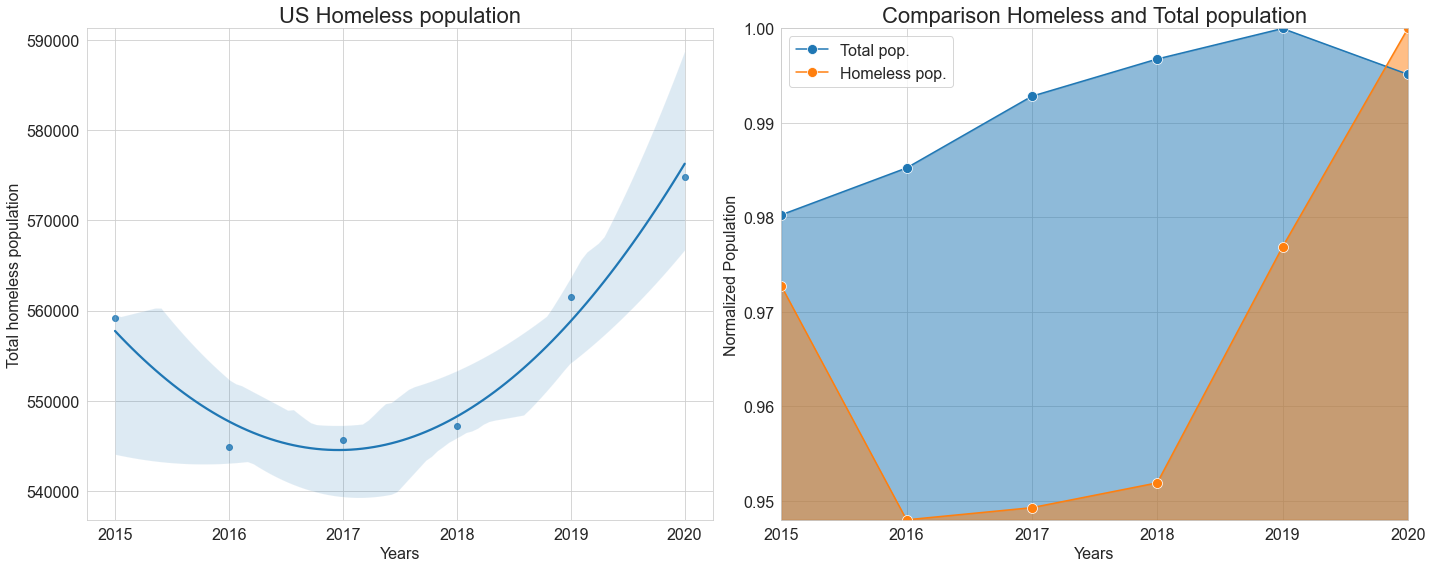

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
_ = sns.regplot(x=total_pt.index,
                y="Homeless pop",
                data=total_pt,
                ax=ax1,
                order=2
                )

_ = sns.lineplot(x=total_pt.index, y="Pop adim",
                 data=total_pt,
                 ax=ax2, color=blue, label='Total pop.',
                 marker='o', markersize=10)
ax2.fill_between(x=total_pt.index,
                 y1=total_pt["Homeless adim"].min(),
                 y2=total_pt["Pop adim"],
                 color=blue,
                 alpha=0.5)
_ = sns.lineplot(x=total_pt.index, y="Homeless adim",
                 data=total_pt,
                 ax=ax2, color=orange, label='Homeless pop.',
                 marker='o', markersize=10)
ax2.fill_between(x=total_pt.index,
                 y1=total_pt["Homeless adim"].min(),
                 y2=total_pt["Homeless adim"],
                 color=orange,
                 alpha=0.5)
ax2.set(ylabel="Normalized Population", xlabel="Years",
       xlim=[2015, 2020], ylim=[total_pt["Homeless adim"].min(), 1])
ax2.legend(loc='best')
ax2.set_title("Comparison Homeless and Total population")

ax1.set(ylabel="Total homeless population", xlabel="Years")
ax1.set_title("US Homeless population")

plt.tight_layout()
plt.show()

## More details about homeless population

In [15]:
years = raw_data_df["Year"].unique().tolist()

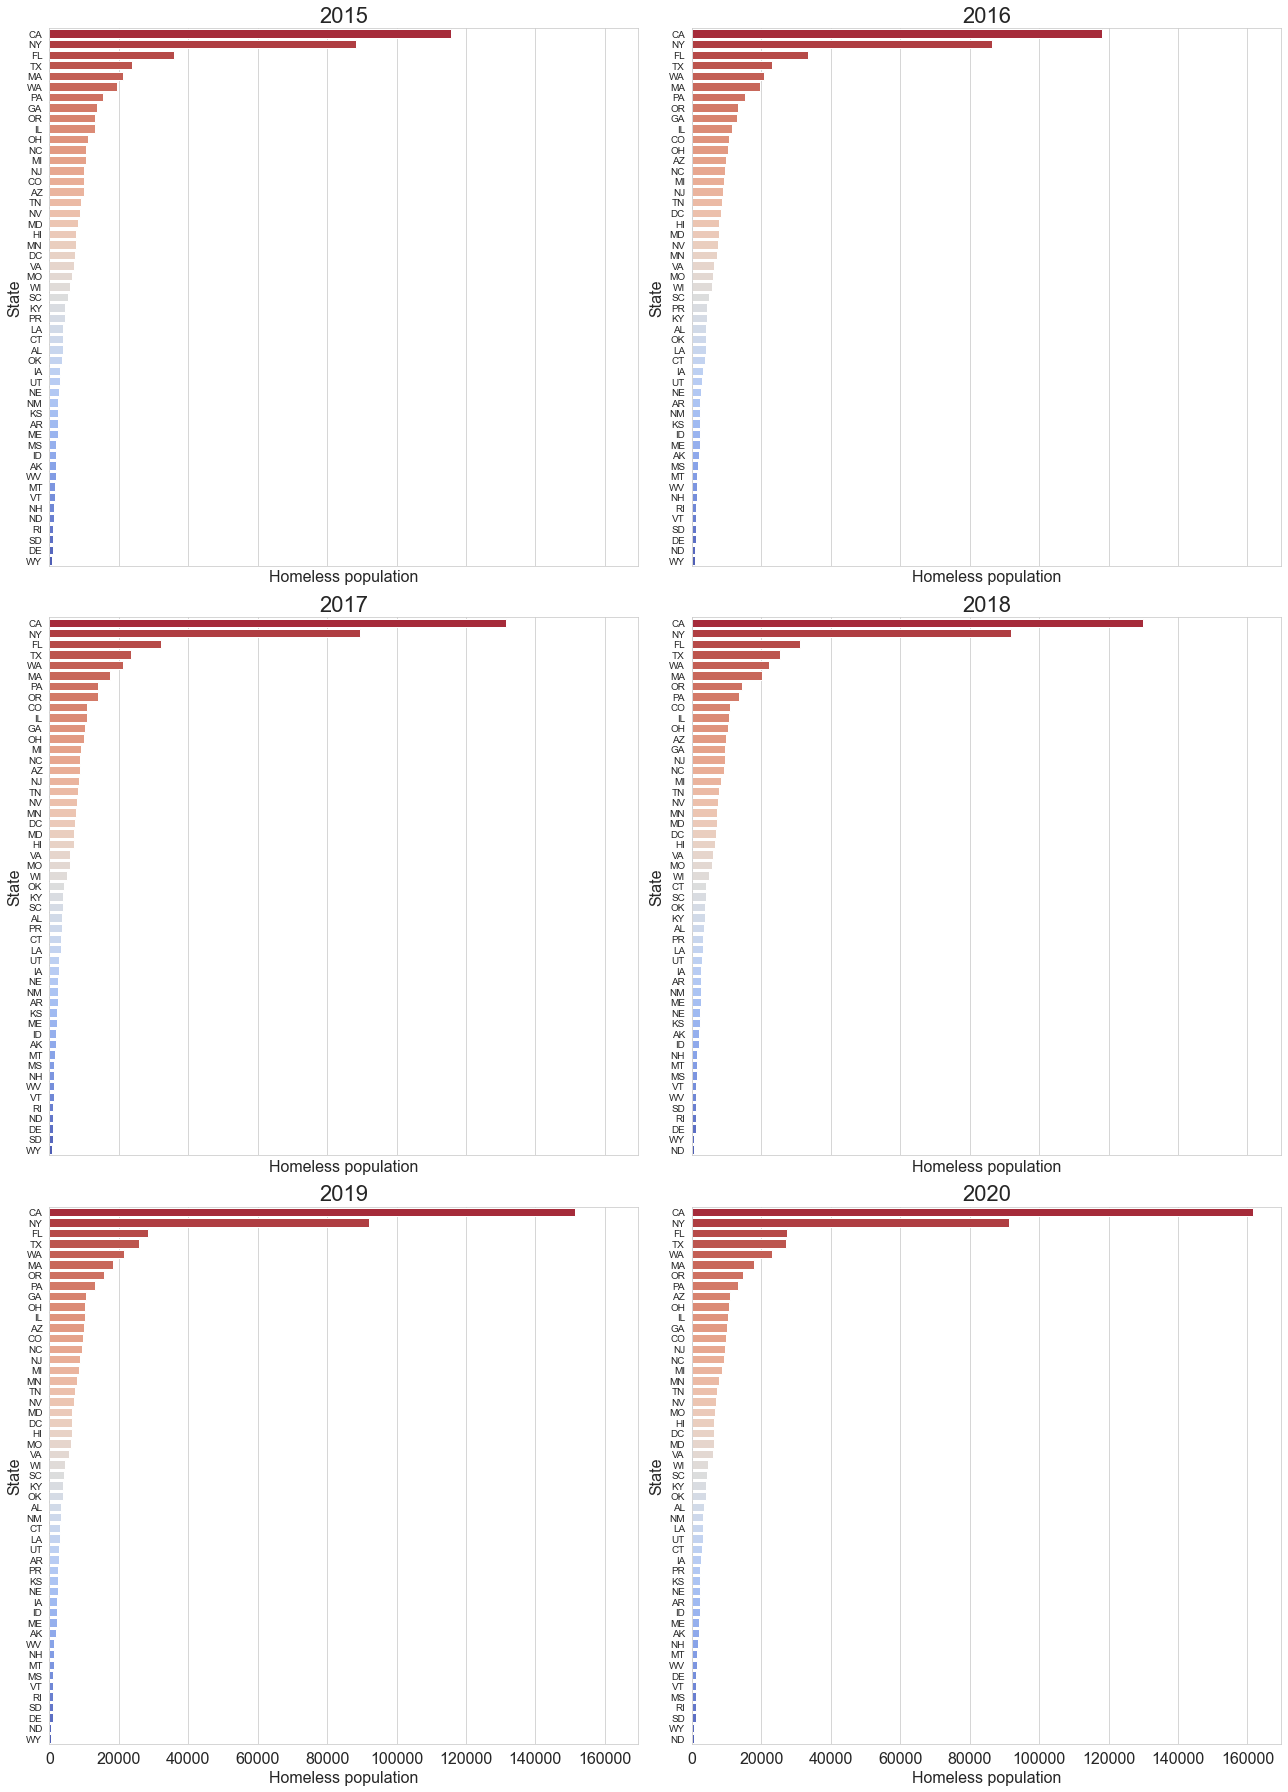

In [16]:
_, axes = plt.subplots(3, 2, figsize=(18, 25), sharex=True)
for year, ax in zip(years, axes.ravel()):
    df = raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", ascending=False)
    _ = sns.barplot(y="State abbr", x="Homeless pop", data=df, ax=ax, palette="coolwarm_r")
    ax.set_title(year)
    ax.set(xlabel="Homeless population", ylabel="State")
    ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

### Top 10 States Overall Homeless population from 2015 - 2020

Based on those figures, CA is the state with a higher homeless population. Besides, there were no massive changes in the states with homeless people during the last four years.

Let's see what are the top 10 states

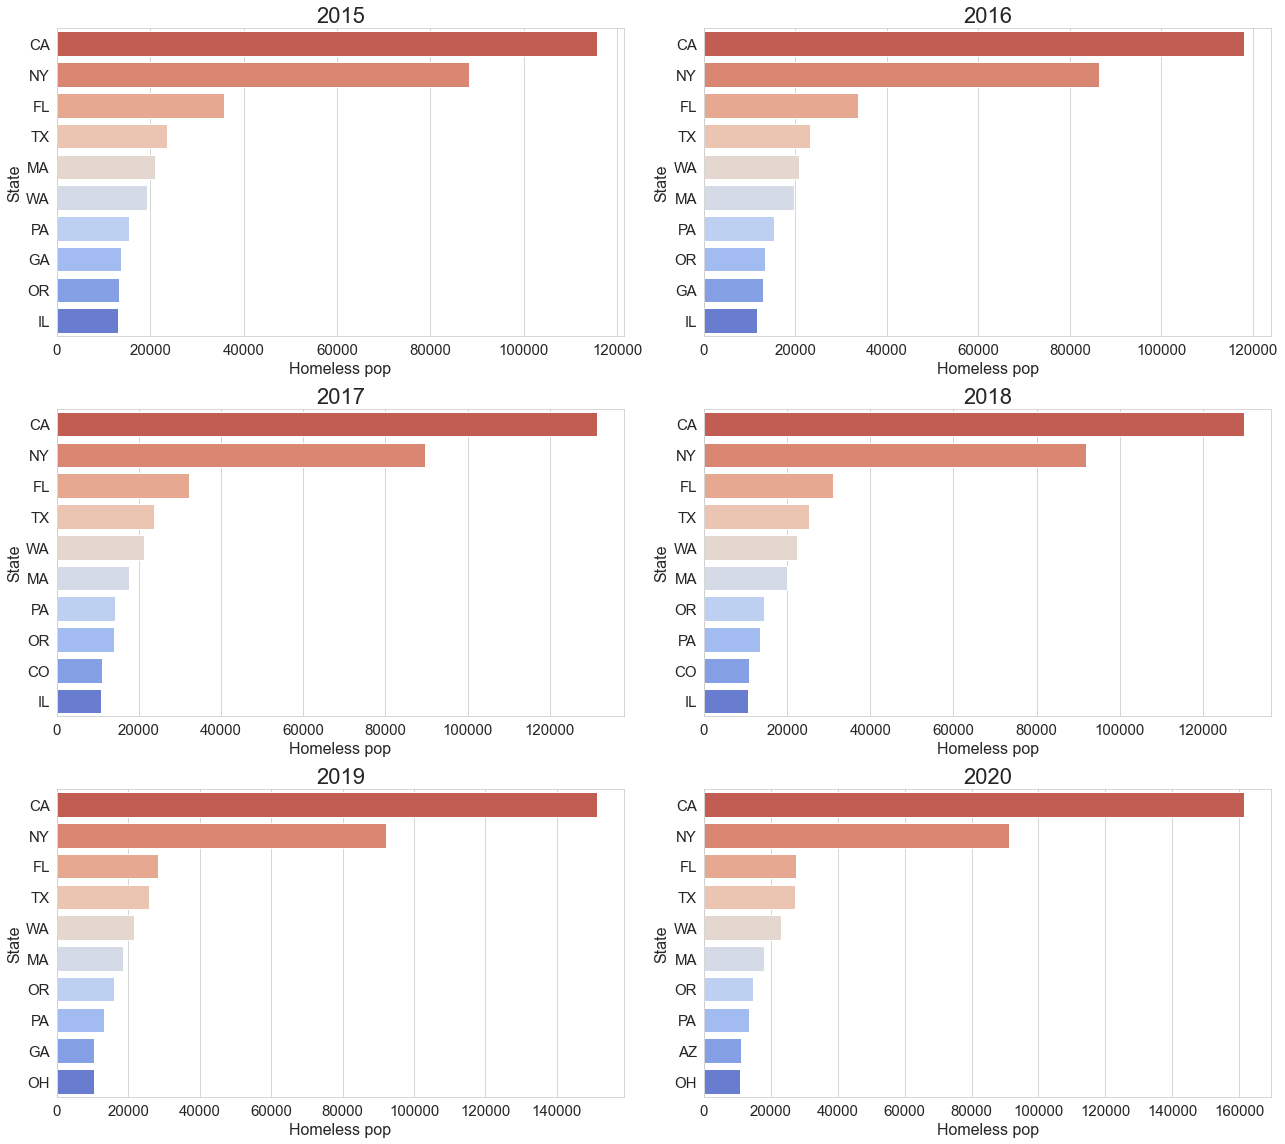

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
for year, ax in zip(years, axes.ravel()):
    df = raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", ascending=False)
    _ = sns.barplot(y="State abbr", x="Homeless pop", data=df.head(10),
                    palette="coolwarm_r", ax=ax, orient="h")
    ax.set_title(year)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set(xlabel="Homeless pop", ylabel="State")
plt.tight_layout()
plt.show()

The top ten states list isn't kept constant during the period study. 
Let's find out which states were on the top 10 list per year

In [18]:
top_states_index = []
for year in years:
    top_states_index.extend(raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", ascending=False).head(10).index.to_list())

In [19]:
# Let's put this into a dataframe
top_states_df = raw_data_df.loc[top_states_index, "State name"]
top_states_df.reset_index(inplace=True, drop=True)

In [20]:
name_top_states = top_states_df.unique()
print("Between {} and {}, these are the {} states that has been reported in the top 10 homeless population".format(min(years), max(years), len(name_top_states)))

name_top_states

Between 2015 and 2020, these are the 13 states that has been reported in the top 10 homeless population


array(['California', 'New York', 'Florida', 'Texas', 'Massachusetts',
       'Washington', 'Pennsylvania', 'Georgia', 'Oregon', 'Illinois',
       'Colorado', 'Ohio', 'Arizona'], dtype=object)

What are the US regions where those states belong to?

In [21]:
query = ("SELECT sr.abbreviation, "
         "sr.name, sr.region "
         "FROM state_region AS sr "
         "WHERE sr.name IN (" + "'" +"','".join(name_top_states.tolist()) + "')")
which_states = cheroku.make_query(query, "c1_capstone", credential_file)

In [22]:
which_states

,abbreviation,name,region
0,AZ,Arizona,Southwest
1,CA,California,West
2,CO,Colorado,West
3,FL,Florida,South
4,GA,Georgia,South
5,IL,Illinois,Midwest
6,MA,Massachusetts,New England
7,NY,New York,Middle Atlantic
8,OH,Ohio,Midwest
9,OR,Oregon,West


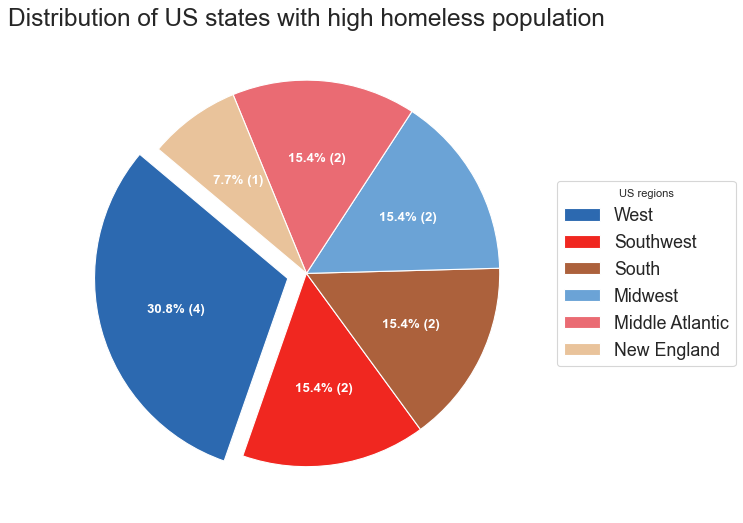

In [23]:
fig, ax = plt.subplots(figsize=(14, 8), 
                       subplot_kw=dict(aspect="equal"), 
                       dpi= 80)

data = which_states["region"].value_counts()
categories = which_states["region"].value_counts().index
explode = [0.1,0,0,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  colors=palettable.tableau.BlueRed_6.mpl_colors,
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="US regions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight=700)
ax.set_title("Distribution of US states with high homeless population")
plt.show()

From the last figure, it can be shown the US-region where most high-homeless population states are located in the West region.

## How has changed the homeless population of those states over time?

In order to show the variation over time, let's do a lineplot.

In [24]:
top_states_df = raw_data_df[raw_data_df["State name"].isin(name_top_states)]

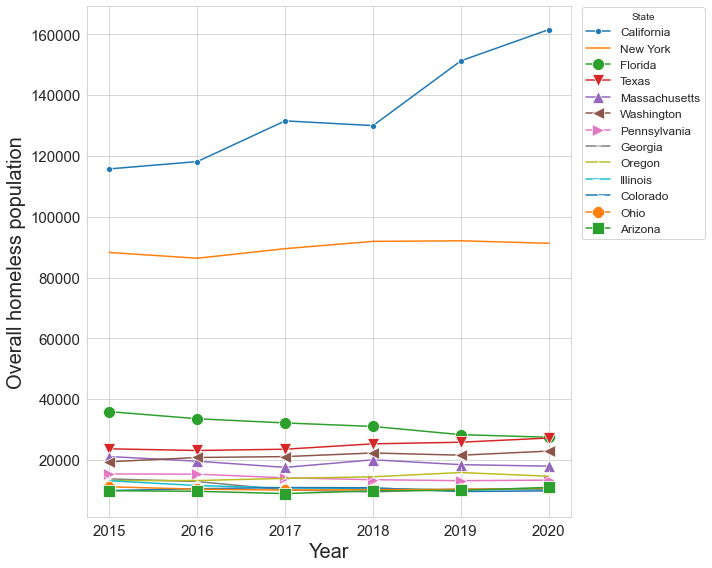

In [25]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="Year", y="Homeless pop",
                     data=top_states_df[top_states_df["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

Based on this figure, California (CA) is the state where the homelessness population has increased the most from 2018 to 2020. The New York state (NY) has shown a continuous homelessness increase.

In contrast, Florida (FL) has shown a continuous decrease since 2015. Let's see the behaviour of the rest of the states.

Due the magnitud order, the homeless population for the rest of the states has been shrunk to the plot bottom. Because of that, let's split the graph

In [26]:
out_state = ['California', 'New York', 'Florida']
new_top_states = [i for i in name_top_states if i not in out_state]

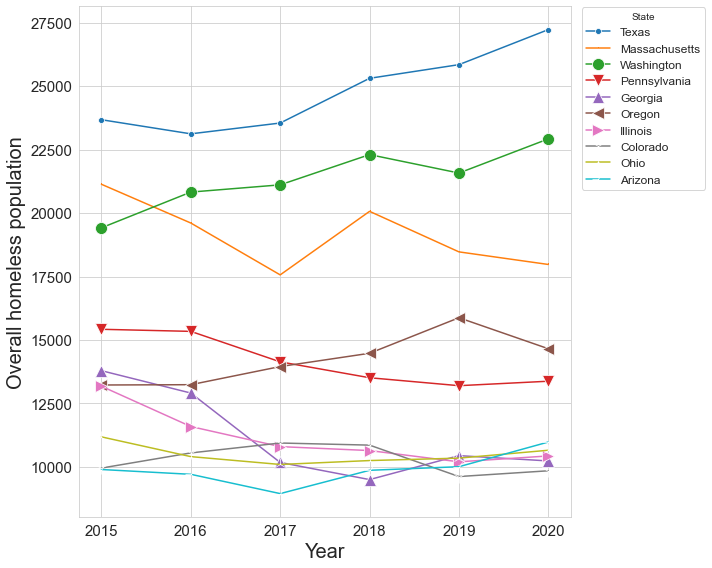

In [27]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(new_top_states):
    _ = sns.lineplot(x="Year", y="Homeless pop",
                     data=top_states_df[top_states_df["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=new_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

On the previous graph, it is possible to observe that the homeless population has increased considerably in Texas and Washington states. In contrast, Pennsylvania and  Illinois show that growth slowed down noticeably.
An interesting case is Georgia state, where homelessness has decreased dramatically. Finally, Colorado state shows a steady level, while Ohio appeared on the map in 2019 with a 3%-increase in the homeless population.

## Ratio Homeless population vs Total population in Top States

Let's see how the homeless population has changed relative to the total population

In [28]:
subdata = top_states_df[["Year", "State name", "Population", "Homeless pop"]].copy()
subdata["% homeless"] = subdata["Homeless pop"] /subdata["Population"] * 100

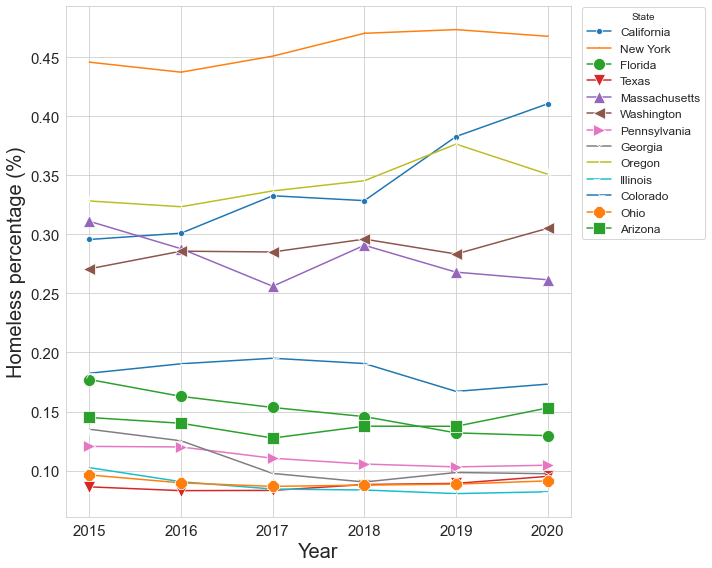

In [29]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="Year", y="% homeless",
                     data=subdata[subdata["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Homeless percentage (%)', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

From the graph, the set of top homeless population states can be split at 0.25% level.

In [30]:
df1 = subdata[subdata["% homeless"] > 0.25]
df2 = subdata[subdata["% homeless"] < 0.25]

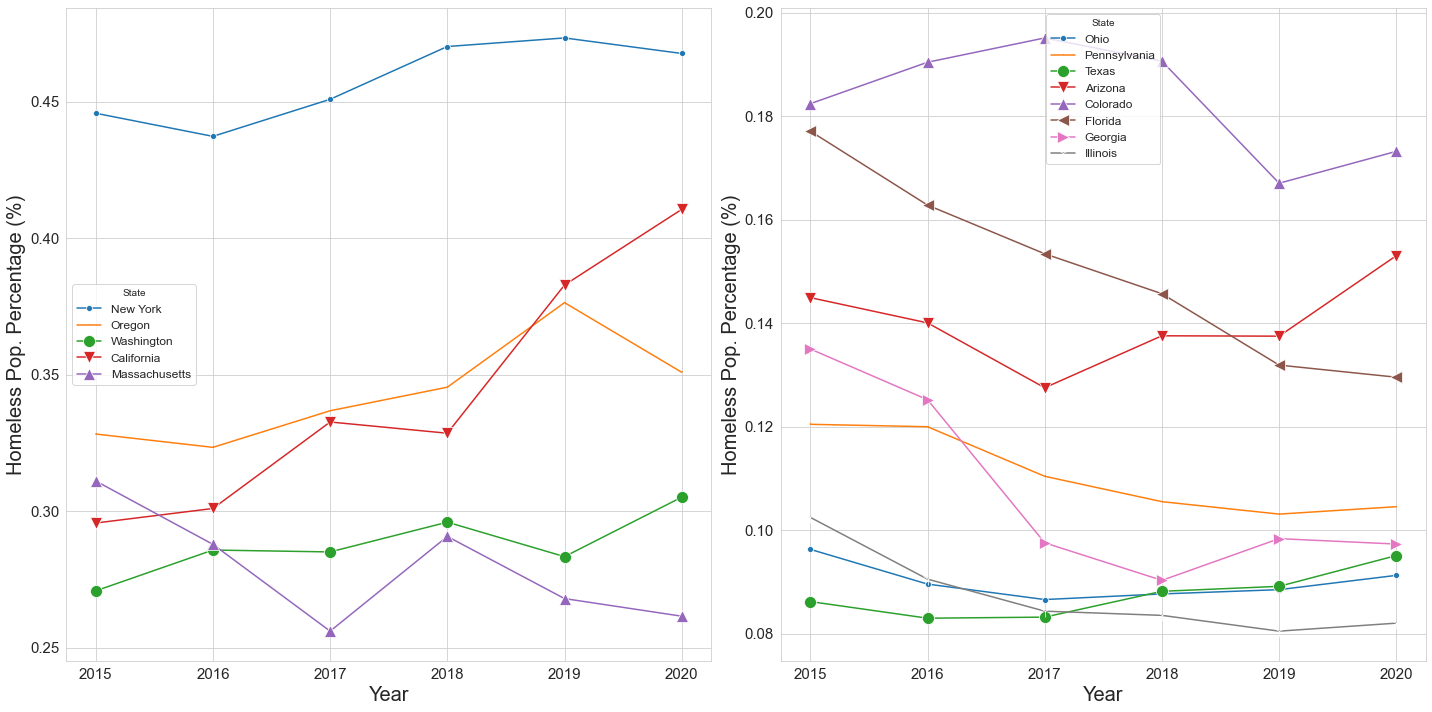

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
dataframes = [df1, df2]
for dataframe, ax in zip(dataframes, axes.ravel()):
    states = dataframe["State name"].unique().tolist()
    for i, state in enumerate(states):
        _ = sns.lineplot(x="Year", y="% homeless", 
                         data=dataframe[dataframe["State name"] == state],
                         palette=palettable.tableau.BlueRed_6.mpl_colors,
                         marker=all_shapes[i], markersize=12, ax=ax)

    ax.set_ylabel('Homeless Pop. Percentage (%)', fontsize=20)
    ax.legend(labels=states, title = "State",
               fontsize = 'large', loc="best")
    ax.set_xlabel('Year', fontsize=20)
    ax.tick_params(which='major', labelsize=15)

plt.tight_layout()

In [32]:
subdata.groupby(["State name"])["% homeless"].agg(['mean', 'std']).sort_values(by="std", ascending=False)

,mean,std
State name,,
California,0.341894,0.045757
Massachusetts,0.279207,0.020963
Oregon,0.343536,0.019093
Florida,0.150073,0.018300
Georgia,0.107287,0.018175
New York,0.457563,0.014874
Washington,0.287690,0.011720
Colorado,0.183129,0.011054
Arizona,0.140096,0.008513


The selection of states will be those whose std % homeless is higher than 0.0115

In [33]:
final_state_list = subdata.groupby(["State name"])["% homeless"].agg('std').sort_values(ascending=False)
final_state_list[final_state_list.values > 0.0115].index.tolist()

['California',
 'Massachusetts',
 'Oregon',
 'Florida',
 'Georgia',
 'New York',
 'Washington']

## Comparing some features related to the 25 years and over US population

The main project goal is to analyze recent US population data to answer the question: *Will a rent cost increment increase the risk of people who have been awarded a degree experiencing homelessness?*

Because of that, in the following section, a comparison between the US 25-year-and-over population is shown.

Let's create a pivot table where the 25 year and over population is summed by year

In [34]:
year25_pt = pd.pivot_table(
    data=indexed_data_df,
    index="Year",
    values=["Pop. 25year+ educ", "Pop. 25year+ no schooling", "Pop. 25year+ bachelor", "Pop. 25year+ master over"],
    aggfunc='sum'
)


In [35]:
year25_pt

,Pop. 25year+ bachelor,Pop. 25year+ educ,Pop. 25year+ master over,Pop. 25year+ no schooling
Year,,,,
2015,41576643,218829689,35944674,3191717
2016,42675515,220847677,37397456,3197250
2017,44013586,223593758,39171256,3238045
2018,45029878,225446877,40358458,3305133
2019,46174068,227200303,41359648,3360924
2020,45478307,225168128,40665846,3513496


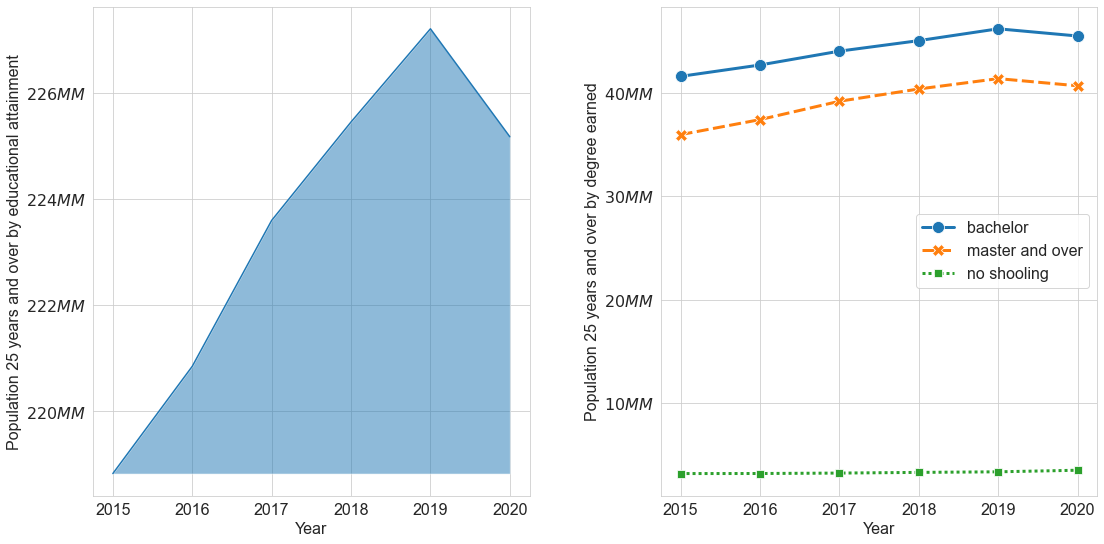

In [36]:
def format_func(value, tick_number):
    return r"${:.0f}MM$".format(value / 1e6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
_ = sns.lineplot(x=year25_pt.index,
                 y='Pop. 25year+ educ',
                 data=year25_pt,
                 ax=ax1)
ax1.fill_between(x=year25_pt.index, 
                 y1=year25_pt['Pop. 25year+ educ'].min(), 
                 y2=year25_pt['Pop. 25year+ educ'], alpha=0.5)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax1.set(ylabel="Population 25 years and over by educational attainment")

_ = sns.lineplot(x='Year',
                 y='value',
                 hue='variable',
                 data=pd.melt(year25_pt.drop('Pop. 25year+ educ', axis=1).reset_index(), ["Year"]),
                 ax=ax2,
                 lw=3,
                 markers=True,
                 style='variable', 
                 markersize=12)
ax2.set(ylabel="Population 25 years and over by degree earned")
ax2.legend(labels=['bachelor', 'master and over', 'no shooling'],
           loc='best')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
fig.subplots_adjust(wspace=.3)
plt.show()


From the left plot, the 25year population who have earned a formal educational level increased by around 4% from 2015 to 2019. However, in 2020, an almost 1% decrease is shown. On the left graph, the bachelor's graduate population has kept 30% higher than the master's and above graduates from 2015 to 2020.

Interestingly, the population who haven't finished schooling has risen steadily to 1% of the total 25-year population during the same timespan.

## Comparing some features related to in labor force and in households US population

In [37]:
some_population_pt = pd.pivot_table(
    data=indexed_data_df.loc[2017:],
    index="Year",
    values=["Population", "Pop in households", "Pop in labor force", "Bachelor+ in labor force"],
    aggfunc='sum'
)

In [38]:
some_population_pt

,Bachelor+ in labor force,Pop in households,Pop in labor force,Population
Year,,,,
2017,49486843,121254123,165928662,329056355
2018,50702924,122699817,167091685,330362592
2019,51941004,123973834,168719014,331433217
2020,51234055,123559968,167113763,329824950


In [39]:
color = 'white'
mpl.rcParams['text.color'] = color
mpl.rcParams['font.size'] = 16
cmap = palettable.tableau.BlueRed_6.mpl_colormap
years = [2017, 2018, 2019, 2020]

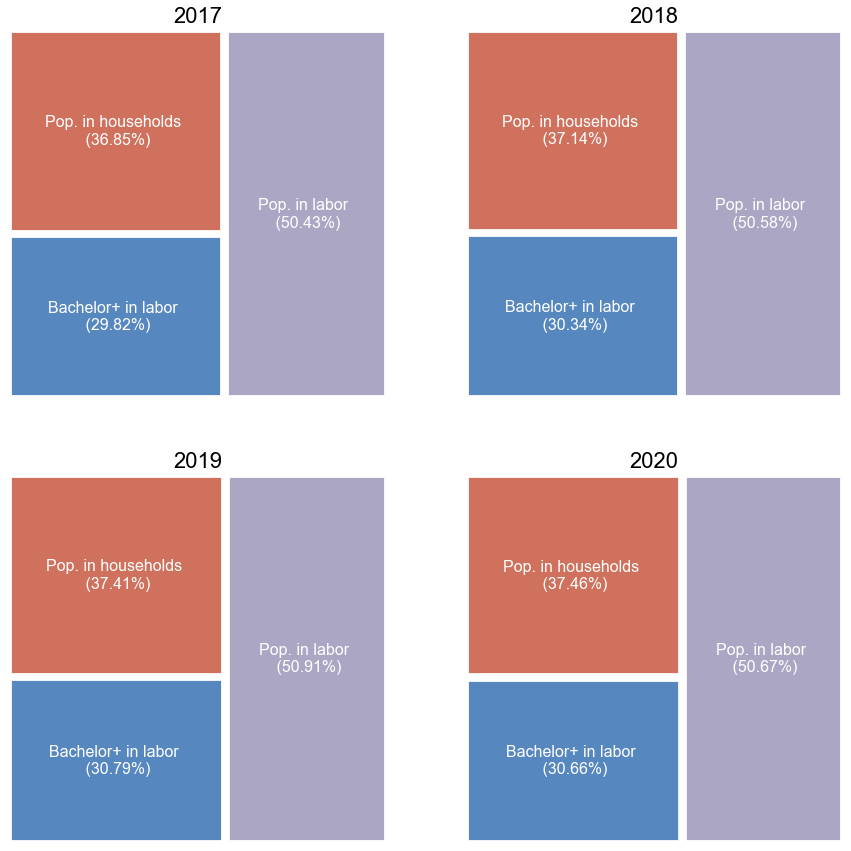

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for year, ax in zip(years, axes.ravel()):
    temp_df = some_population_pt.loc[year]
    names = ["Bachelor+ in labor", "Pop. in households", "Pop. in labor"]
    sizes = np.round(np.array([temp_df["Bachelor+ in labor force"]/temp_df["Pop in labor force"],
                               temp_df["Pop in households"]/temp_df["Population"],
                               temp_df["Pop in labor force"]/temp_df["Population"]])*100, 2)
    labels = [n + ' \n (' + str(i) + '%)' for n, i in zip(names, sizes)]
    mapped_list = [cmap(i) for i in np.arange(0, 1, 1/len(sizes))]


    squarify.plot(sizes=sizes,
                  label=labels,
                  color=mapped_list,
                  alpha=.8,
                  pad=True, ax=ax)
    ax.set_title(year, c='black')
    ax.axis("off")
plt.show()